In [1]:
import atlas

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp

%matplotlib inline

# Custom chemical abundances

<div class="alert alert-block alert-info">
    <b>Note:</b> In this example, we calculate a fully self-consistent model atmosphere. This means that the same stellar parameters and chemical abundances are used in both structure calculation and spectral synthesis. If a large number of models is required (e.g. when fitting a model to an observed spectrum), it may be more computationally efficient to reuse the same structure and only recompute the spectrum. This can be attained using the <code>abun_adjust</code> optional argument in <code>atlas.synthe()</code>. Unlike some other spectral synthesis codes, <code>SYNTHE</code> recomputes the chemical and ionization equilibria during the spectral synthesis (only the temperature and pressure profiles are taken from the structure model), which makes this approximation especially robust.
<br><br>
    Even then, certain elements (e.g. molecular contributors such as carbon, oxygen and titanium, or electron donors such as sodium and magnesium) will have a noticeable effect on the structure, rendering this approximation invalid.
</div>

In this example, we calculate a synthetic spectrum for the K giant **Arcturus**, which has the following parameters ([Ramírez+2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...743..135R/abstract)):

<table width=500>
  <tr><td>Effective temperature, $T_\mathrm{eff}$</td><td>$4286\ \mathrm{K}$</td></tr>
  <tr><td>Surface gravity, $\log(g)$</td><td>$1.66$</td></tr>
  <tr><td>$[\mathrm{M/H}]\approx[\mathrm{Fe/H}]$</td><td>$-0.52$</td></tr>
  <tr><td>$[\mathrm{C/M}]$</td><td>$0.43$</td></tr>
  <tr><td>$[\mathrm{O/M}]$</td><td>$0.5$</td></tr>
  <tr><td>$[\mathrm{Na/M}]$</td><td>$0.11$</td></tr>
  <tr><td>$[\mathrm{Mg/M}]$</td><td>$0.37$</td></tr>
  <tr><td>$[\mathrm{Al/M}]$</td><td>$0.34$</td></tr>
  <tr><td>$[\mathrm{Si/M}]$</td><td>$0.33$</td></tr>
  <tr><td>$[\mathrm{K/M}]$</td><td>$0.2$</td></tr>
  <tr><td>$[\mathrm{Ca/M}]$</td><td>$0.11$</td></tr>
  <tr><td>$[\mathrm{Sc/M}]$</td><td>$0.23$</td></tr>
  <tr><td>$[\mathrm{Ti/M}]$</td><td>$0.23$</td></tr>
  <tr><td>$[\mathrm{V/M}]$</td><td>$0.2$</td></tr>
  <tr><td>$[\mathrm{Cr/M}]$</td><td>$-0.05$</td></tr>
  <tr><td>$[\mathrm{Mn/M}]$</td><td>$-0.21$</td></tr>
  <tr><td>$[\mathrm{Co/M}]$</td><td>$0.09$</td></tr>
  <tr><td>$[\mathrm{Ni/M}]$</td><td>$0.06$</td></tr>
  <tr><td>$[\mathrm{Zn/M}]$</td><td>$0.22$</td></tr>
</table>

In the table above, all abundance ratios are given with respect to the standard solar values. In `BasicATLAS`, stellar parameters are specified through the `Settings()` class. First, create an instance of this class:

In [2]:
settings = atlas.Settings()

By default, the object will contain solar parameters. For instance, print the currently set effective temperature and surface gravity:

In [3]:
print('Teff: {} K'.format(settings.teff))
print('log(g): {}'.format(settings.logg))

Teff: 5770.0 K
log(g): 4.44


We can also display the adopted standard solar abundances as follows:

In [4]:
print(settings.abun_solar())

OrderedDict([('H', 12.0), ('He', 10.98), ('Li', 3.26), ('Be', 1.38), ('B', 2.79), ('C', 8.5), ('N', 7.86), ('O', 8.76), ('F', 4.56), ('Ne', 8.02), ('Na', 6.24), ('Mg', 7.6), ('Al', 6.45), ('Si', 7.51), ('P', 5.46), ('S', 7.16), ('Cl', 5.5), ('Ar', 6.4), ('K', 5.11), ('Ca', 6.34), ('Sc', 3.15), ('Ti', 4.95), ('V', 3.93), ('Cr', 5.64), ('Mn', 5.43), ('Fe', 7.52), ('Co', 4.99), ('Ni', 6.22), ('Cu', 4.19), ('Zn', 4.56), ('Ga', 3.04), ('Ge', 3.65), ('As', 2.3), ('Se', 3.34), ('Br', 2.54), ('Kr', 3.25), ('Rb', 2.36), ('Sr', 2.87), ('Y', 2.21), ('Zr', 2.62), ('Nb', 1.46), ('Mo', 1.88), ('Tc', -99.99), ('Ru', 1.75), ('Rh', 1.06), ('Pd', 1.65), ('Ag', 1.2), ('Cd', 1.71), ('In', 0.76), ('Sn', 2.04), ('Sb', 1.01), ('Te', 2.18), ('I', 1.55), ('Xe', 2.24), ('Cs', 1.08), ('Ba', 2.18), ('La', 1.1), ('Ce', 1.58), ('Pr', 0.72), ('Nd', 1.42), ('Pm', -99.99), ('Sm', 0.96), ('Eu', 0.52), ('Gd', 1.07), ('Tb', 0.3), ('Dy', 1.1), ('Ho', 0.48), ('Er', 0.92), ('Tm', 0.1), ('Yb', 0.92), ('Lu', 0.1), ('Hf', 0.87

In the output above, all values are expressed as number densities with respect to hydrogen in dex, normalized such that the abundance of hydrogen is 12 dex. To calculate a model for non-solar parameters, the settings object needs to be altered accordingly:

In [5]:
settings.teff = 4286           # Effective temperature in K
settings.logg = 1.66           # Surface gravity as log10(CGS)
settings.zscale = -0.52        # Metallicity, [M/H]

# Enhancements of individual chemical elements with respect to standard solar
# Only specify non-solar values (no need to input zeroes)
settings.abun = {'C': 0.43, 'O': 0.50, 'Na': 0.11, 'Mg': 0.37, 'Al': 0.34, 'Si': 0.33,
                 'K': 0.20, 'Ca': 0.11, 'Sc': 0.23, 'Ti': 0.23, 'V': 0.20, 'Cr': -0.05,
                 'Mn': -0.21, 'Co': 0.09, 'Ni': 0.06, 'Zn': 0.22}

<div class="alert alert-block alert-info">
    <b>Note:</b> If necessary, the helium mass fraction of the atmosphere can be specified with <code>settings.Y</code>. This parameter defaults to $-0.1$ which is a special value that is automatically replaced with the standard solar helium abundance. The solar helium abundance in <code>BasicATLAS</code> is given in terms of the number density of helium with respect to hydrogen, and not as the helium mass fraction $Y$. For this reason, the actual value of $Y$ used in models with <code>Y==-0.1</code> will depend on the abundances of metals. On the other hand, the value of $Y$ will remain fixed regardless of metal abundances if it is specified explicitly in the <code>Settings()</code> object by setting <code>Y</code> to anything other than $-0.1$.
    <br><br>
    At any time, the currently used mass fractions of hydrogen ($X$), helium ($Y$) and metals ($Z$) can be retrieved from a <code>Settings()</code> object with the <code>mass_fractions()</code> method.
</div>

## Opacity Distribution Functions

`ATLAS-9` is much faster than most structure codes by virtue of retrieving radiative opacities from pre-tabulated *opacity distribution functions* (ODFs). A complete set of ODFs must be calculated for each chemical composition, which can be accomplished with the satellite utility `DFSYNTHE`. While the ODF calculation may take a considerable amount of time, the result can be reused for all models that have the same chemical composition. A set of solar ODFs is already available in `BasicATLAS` in `data/solar_ODF`, which is used by default. However, in this example we are dealing with a non-solar chemical composition, and a new set of ODFs is required.

We will store the ODFs in `~/DFSYNTHE_ODF`. Make sure the directory does not already exist and if it does, remove it:

In [6]:
rm -rf ~/DFSYNTHE_ODF

Run `DFSYNTHE` with `atlas.dfsynthe()`:

In [7]:
run_dir = os.path.expanduser('~/DFSYNTHE_ODF')

# The "parallel" option allows BasicATLAS to use all CPU cores in order to evaluate ODFs at different
# temperatures in parallel. In the parallel mode, you may notice the temperature calculations being
# completed out of order
atlas.dfsynthe(run_dir, settings, parallel = True)

Will run XNFDF to tabulate atomic and molecular number densities
Launcher created for 57 temperatures from 1995.0 K to 199526.0 K
XNFDF halted
Will run DFSYNTHE to tabulate the ODFs (Opacity Distribution Functions)
4365.0 K done! (18/57)
5754.0 K done! (23/57)
5012.0 K done! (21/57)
6166.0 K done! (24/57)
4571.0 K done! (19/57)
4169.0 K done! (17/57)
5370.0 K done! (22/57)
4786.0 K done! (20/57)
3981.0 K done! (16/57)
3802.0 K done! (15/57)
3631.0 K done! (14/57)
14125.0 K done! (34/57)
3467.0 K done! (13/57)
15849.0 K done! (35/57)
12589.0 K done! (33/57)
10000.0 K done! (31/57)
11220.0 K done! (32/57)
9333.0 K done! (30/57)
8710.0 K done! (29/57)
17783.0 K done! (36/57)
8128.0 K done! (28/57)
19953.0 K done! (37/57)
7586.0 K done! (27/57)
22387.0 K done! (38/57)
31623.0 K done! (41/57)
28184.0 K done! (40/57)
7079.0 K done! (26/57)
25119.0 K done! (39/57)
6607.0 K done! (25/57)
35481.0 K done! (42/57)
44668.0 K done! (44/57)
39811.0 K done! (43/57)
50119.0 K done! (45/57)
56234.0 K d

`atlas.meta()` can be used to inspect the abundances of the new set of ODFs to verify that it has parameters appropriate for our target model:

In [8]:
atlas.meta(run_dir)

{'abun': OrderedDict([('C', 0.43),
              ('O', 0.5),
              ('Na', 0.11),
              ('Mg', 0.37),
              ('Al', 0.34),
              ('Si', 0.33),
              ('K', 0.2),
              ('Ca', 0.11),
              ('Sc', 0.23),
              ('Ti', 0.23),
              ('V', 0.2),
              ('Cr', -0.05),
              ('Mn', -0.21),
              ('Co', 0.09),
              ('Ni', 0.06),
              ('Zn', 0.22)]),
 'Y': 0.2720222432363635,
 'zscale': -0.5200002474083643,
 'type': 'DFSYNTHE'}

Note that `BasicATLAS` will check that the provided set of ODFs is appropriate for target parameters automatically whenever `ATLAS` is run.

## Structure

The model can then be calculated as usual except the new set of ODFs is passed to `atlas.atlas()` as an argument. We will carry out the model calculation in `~/ATLAS_arcturus_test`. Make sure the directory does not already exist:

In [9]:
rm -rf ~/ATLAS_arcturus_test

Run `ATLAS` with the new set of ODFs:

In [10]:
model_dir = os.path.expanduser('~/ATLAS_arcturus_test')
atlas.atlas(model_dir, settings, ODF = run_dir)   # ODFs are provided in the "ODF" parameter
                                                  # Note also that we are using the settings object
                                                  # created before

Chose closest model from the restart grid with (Teff,log(g),[M/H],[a/M],[C/M])=(4300.0,1.5,-0.5,0.4,0.4)
Launcher created
ATLAS-9 halted
Total iterations: 30 | Best iteration: 30
For the best iteration: max[|err|] = 0.168 | max[|de|] = 3.46 | convergence class: GOLD
ATLAS requested/received validation for /home/roman/ATLAS_arcturus_test successful
Finished running ATLAS-9 in 0:00:04.941304 s


The function `atlas.meta()` can be used to retrieve the parameters of the calculated model. Let us double check that the newly calculated model has the expected abundances:

In [11]:
atlas.meta(model_dir)

{'abun': OrderedDict([('C', 0.43),
              ('O', 0.5),
              ('Na', 0.11),
              ('Mg', 0.37),
              ('Al', 0.34),
              ('Si', 0.33),
              ('K', 0.2),
              ('Ca', 0.11),
              ('Sc', 0.23),
              ('Ti', 0.23),
              ('V', 0.2),
              ('Cr', -0.05),
              ('Mn', -0.21),
              ('Co', 0.09),
              ('Ni', 0.06),
              ('Zn', 0.22)]),
 'Y': 0.2720221952170116,
 'zscale': -0.5199930570428494,
 'teff': 4286.0,
 'logg': 1.66,
 'vturb': 2.0,
 'type': 'ATLAS'}

## Spectral synthesis

Finally calculate the synthetic spectrum using `SYNTHE`. For higher accuracy, we may also specify the turbulent velocity (which affects the strengths of all lines) and carbon-12/carbon-13 ratio (which affects carbon-based molecular bands) of Arcturus. These parameters can be estimated for the surface gravity of the star using published empirical relationships.

<div class="alert alert-block alert-info">
    In <code>BasicATLAS</code>, there are two different turbulent velocities. The turbulent velocity used in the structure calculation is specified in <code>settings.vturb</code> (defaults to $2\ \mathrm{km}\ \mathrm{s}^{-1}$) and it must match one of the velocities for which the ODFs were calculated (by default, the options are $0$, $1$, $2$, $4$ and $8\ \mathrm{km}\ \mathrm{s}^{-1}$). The turbulent velocity used in spectral synthesis is specified in the <code>vturb</code> argument of <code>atlas.synthe()</code> (defaults to $1.5\ \mathrm{km}\ \mathrm{s}^{-1}$) and it can have any value.
    <br><br>
    In practice, the effect of turbulent velocity on the structure is much more subtle than it is on the spectrum, so it is valid in most cases to use $2\ \mathrm{km}\ \mathrm{s}^{-1}$ in all structures, and only adjust this value in spectral synthesis, as is done in this example.
</div>

In [12]:
# Relationship between C12/C13 isotope ratio and surface gravity from Kirby+2015
C12C13_kirby_2015 = lambda logg: np.where(logg > 2.7, 50, np.where(logg <= 2.0, 6, 63 * logg - 120))

# Relationship between VTURB and LOGG from Gerasimov+2026
VTURB_LOGG = lambda logg: 2.792 * np.exp(-0.241 * logg -0.118)

# Run spectral synthesis between 400 and 700 nm in air wavelengths
atlas.synthe(model_dir, 400, 700, vturb = VTURB_LOGG(settings.logg),
             C12C13 = C12C13_kirby_2015(settings.logg), air_wl = True)

Adapted the ATLAS-9 model to SYNTHE in output_synthe.out
Launcher created for wavelength range (400, 700), batch 1. Expected number of points: 335770 (buffer 2010001)


199.0it [02:50,  1.17it/s]                                                      


SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_arcturus_test successful
SYNTHE requested/received validation for /home/roman/ATLAS_arcturus_test successful
Total data points: 335770
Saved the spectrum in spectrum.dat
Finished running SYNTHE in 0:02:50.653590 s


Plot synthetic spectrum:

Text(0, 0.5, 'Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

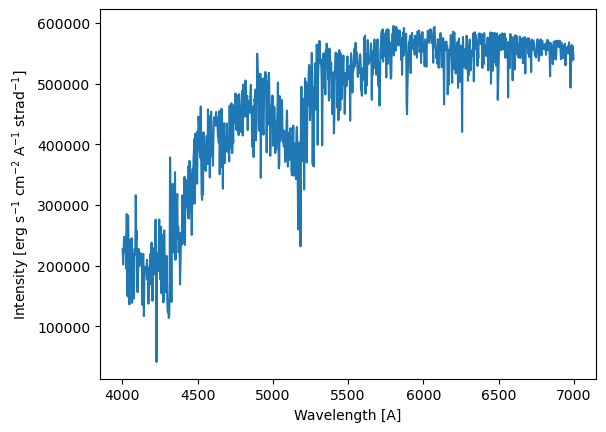

In [13]:
spectrum = atlas.read_spectrum(model_dir, num_bins = 1000)
plt.plot(spectrum['wl'], spectrum['flux'])

plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

## Comparison to observation

We can compare our model spectrum of arcturus to the high-resolution observed spectrum of Arcturus from [Hinkle+2000](https://ui.adsabs.harvard.edu/abs/2000vnia.book.....H/abstract), which is also available in `data/arcturus_hinkle_2000.dat`. The spectrum has already been shifted to the rest frame of reference.

In order to carry out this comparison, we must adjust the continuum and the broadening of the model to match the observation. The observed spectrum of Arcturus is continuum-normalized. `BasicATLAS` also provides the continuum-normalized spectrum in `spectrum['line']`; however, the emirical and model normalizations are going to be slightly different. The model already accounts for line broadening due to the *microturbulent velocity* (the `vturb` argument in `atlas.synthe()`), but the observed spectrum will also display instrumental, rotational and macroturbulent broadening, among other effects.

In the cell below, we use `scipy.optimize.curve_fit()` to find the best-fit values of continuum normalization and Gaussian broadening in the wavelength range between $600$ and $601\ \mathrm{nm}$. For such a narrow range of wavelengths, we can safely approximate the continuum correction as a simple multiplicative factor.

Continuum correction = 1.69e-06 | Broadening = 2.59 km/s


(6000.0, 6010.0)

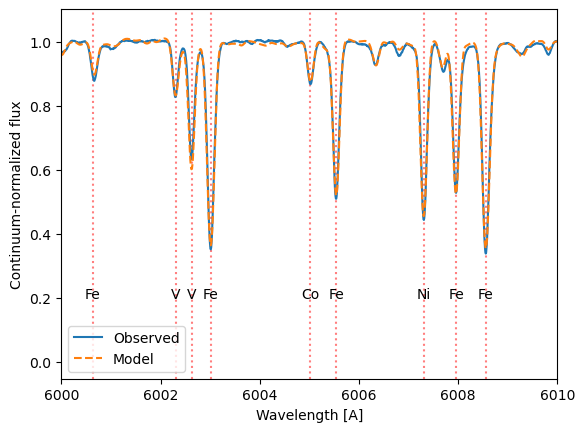

In [14]:
# Load the observed spectrum of Arcturus
observed_wl, observed_flux = np.loadtxt('../data/arcturus_hinkle_2000.dat', unpack = True)

# Load the model spectrum of Arcturus (no binning)
spectrum = atlas.read_spectrum(model_dir)

# Function to apply continuum correction (multiplicative factor) and broadening (in km/s)
def correct_spectrum(wl, continuum_factor, broadening):
    # Convert the broadening value from km/s to wavelength points at ~6000 A and R=600,000
    sigma = broadening * 600000 / (scp.constants.c * 1e-3)
    # Apply the corrections
    corrected_flux = scp.ndimage.gaussian_filter1d(spectrum['flux'] * continuum_factor, sigma)
    # Interpolate the model spectrum onto the wavelength sampling of the observation
    return np.interp(wl, spectrum['wl'], corrected_flux)

# Determine the continuum correction and broadening
mask = (observed_wl > 6000) & (observed_wl < 6010) # Focus on 600-601 nm
best_fit = scp.optimize.curve_fit(correct_spectrum, observed_wl[mask], observed_flux[mask])
print('Continuum correction = {:.2e} | Broadening = {:.2f} km/s'.format(*best_fit[0]))

# Plot the observed and model spectra
plt.plot(observed_wl, observed_flux, label = 'Observed')
plt.plot(spectrum['wl'], correct_spectrum(spectrum['wl'], *best_fit[0]), '--', label = 'Model')

# Show identifications for strong lines (from NIST)
lines = {
    'Fe': [6000.6273, 6003.0108, 6005.5409, 6007.9594, 6008.5556],
    'V': [6002.3026, 6002.6241],
    'Co': [6005.02],
    'Ni': [6007.310],
}
for element in lines:
    for line in lines[element]:
        plt.axvline(line, color = 'r', alpha = 0.5, ls = ':', zorder = -5)
        plt.text(line, 0.2, element, ha = 'center')

plt.xlabel('Wavelength [A]')
plt.ylabel('Continuum-normalized flux')
plt.legend()
plt.xlim(6000, 6010)